# K-means from scratch

* Cluster unlabeled data
* Partition all observations into different clusters in which each observation belongs to the cluster with the nearest mean

Load julia modules

In [27]:
using PyPlot
using Random
using Statistics

Generate some sample data

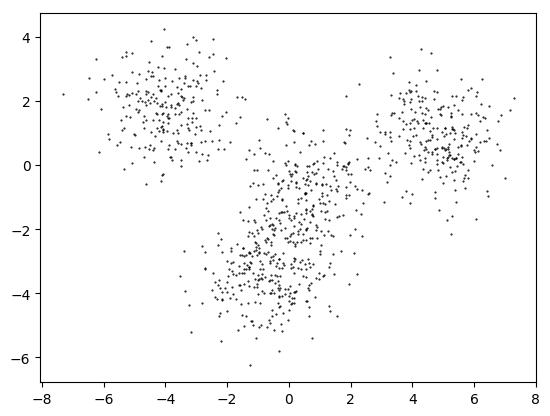

2×1000 Array{Float64,2}:
 -0.238954  -2.81391  5.79397   0.200144  …  0.143204  5.91416  5.53676 
 -4.96322    2.02804  1.2531   -2.92428      1.0862    1.59531  0.095083

In [28]:
# number of data points
N = 1000
# number of dimensins
n = 2
# generate random data
Random.seed!(1234)

x = randn(n,N)
# number of clusters
nc = 4
xc_true = 3 * randn(n,nc)

for i = 1:N
    ic = rand(1:nc)
    x[:,i] = xc_true[:,ic] + randn(2)
end

plot(x[1,:],x[2,:],"k.",markersize = 1);
x

* observations ($\mathbf x_1, \mathbf x_2, ... \mathbf x_n$) where each observation is a vector
* partition the $n$ observations into $k$ sets ($S_1,S_2,...S_k$)
* minimizing the within-cluster sum of squares (WCSS) which is related to the variance.

$$ \left\| \mathbf x - \boldsymbol\mu_i \right\|^2$$

$$\ \sum_{i=1}^{k} \sum_{\mathbf x \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2$$

$$ {\mathrm{arg\,min}}  \sum_{i=1}^{k} \sum_{\mathbf x \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2$$


$$\underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^{k} \sum_{\mathbf x \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2$$

* $\boldsymbol \mu_i$ is the mean of points in $S_i$.
* This is equivalent to minizing the pairwise squared deviations of points in the same cluste:

$$\underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^{k} \, \frac{1}{2 |S_i|} \, \sum_{\mathbf{x}, \mathbf{y} \in S_i} \left\| \mathbf{x} - \mathbf{y} \right\|^2$$

Let's try to find the centroid of the $k$ clusters. Here $k$ is 4 

In [29]:
k = 4

4

 Pick $k$ random elements of $x$ as initial centroids. This is the Forgy method for initialization.

In [30]:
xc = x[:,rand(1:N,k)]

2×4 Array{Float64,2}:
 -1.0976  3.73449  -0.325269  5.17048 
 -3.5402  1.90456  -2.94145   0.267609

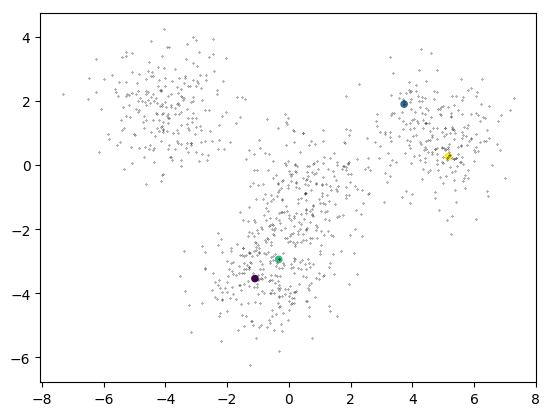

In [31]:
plot(x[1,:],x[2,:],"k.",markersize=0.5)
scatter(xc[1,:],xc[2,:],20,1:k);

We are just using the Euclidian distance here

In [32]:
distance(x,y) = sum((x-y).^2)

distance (generic function with 1 method)

To each data point $x_i$ (`x[:,i]`) assign the label correspond to the closest centroid.

In [33]:
label = zeros(Int,N)

function assignlabel!(x,xc,distance,label)
    N = size(x,2)
    k = size(xc,2)
    for i = 1:N
      mindist = 1e10
      for j = 1:k
        dist = distance(x[:,i],xc[:,j])
        if dist < mindist
           label[i] = j
           mindist = dist
        end
      end
    end
end
assignlabel!(x,xc,distance,label)

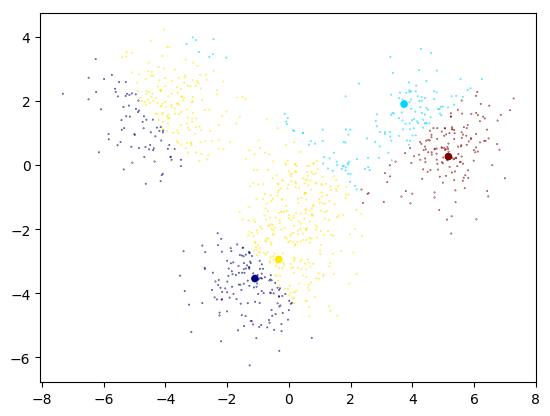

In [34]:
function plotcluster(x,label,xc)
    k = size(xc,2)
    scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet")
    scatter(x[1,:],x[2,:],0.1,label; cmap = "jet")
end
plotcluster(x,label,xc);

Update the centroids `xcnew` based on the labels

In [35]:
function updatemeans!(x,label,xcnew)
  k = size(xcnew,2)

  for j = 1:k;
    xcnew[:,j] = mean(x[:,label .== j],dims = 2)
  end
end

xcnew = similar(xc)
updatemeans!(x,label,xcnew)
xcnew

2×4 Array{Float64,2}:
 -2.53077  2.9094   -1.02829   5.1709  
 -2.16187  1.42987  -0.570022  0.380128

Old and new centroids (light and draker color)

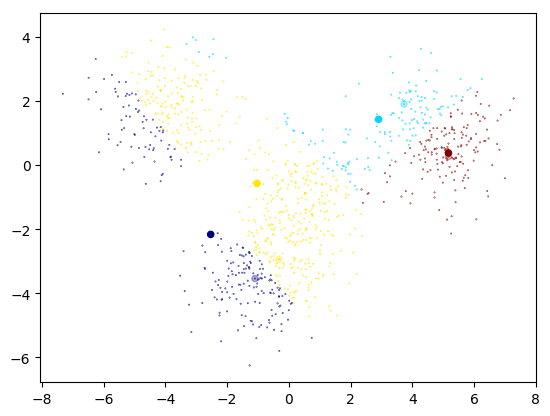

In [36]:
plotcluster(x,label,xcnew)
scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet", alpha = 0.3);

Iterate over label assignmement and updating the centroids

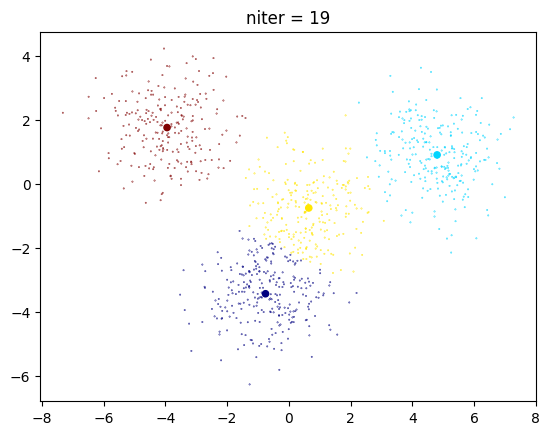

┌ Info: Converged
└ @ Main In[37]:18


In [37]:
xc = x[:,rand(1:N,k)]
nmaxiter = 100
newlabel = zeros(Int,N)
fig = figure()
for niter = 1:nmaxiter
    assignlabel!(x,xc,distance,newlabel)
    updatemeans!(x,newlabel,xcnew)
 
    xc .= xcnew
    plotcluster(x,newlabel,xcnew)
    title("niter = $(niter)")
    sleep(1)
    IJulia.clear_output(true)
    display(fig)
    clf()
    
    if label == newlabel
        @info "Converged"
        break
    end
    label .= newlabel     
end



Note how sometimes the algorithm does not converge

In [38]:
xc

2×4 Array{Float64,2}:
 -0.754602  4.80477    0.646769  -3.94462
 -3.42157   0.912755  -0.744018   1.76655

In [39]:
xc_true

2×4 Array{Float64,2}:
 -3.91166   0.526458  -0.789345  4.7484  
  1.76087  -0.828008  -3.40463   0.877456

Note the connection to the [Voroni diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)
